Import Section

In [ ]:
from PIL import Image
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Preparing Dataset

dataset link: https://www.kaggle.com/datasets/kaushalsethia/alzheimers-adni/data

In [ ]:
images = [] # MRI images
images_copy = [] # Copy when needed
labels = [] # MRI diagnosis result
classes = ['AD', 'MCI', 'NC']   # Diagnosis classes (Alzheimer’s Disease, Mild Cognitive Impairment, Normal Controls)

#Get the images, also make sure they all RGB images (maybe some images are saved in different formats)
for i in classes:
    folder_path = "C://Users//lenovo//Desktop//محمد عبدالفتاح//DIP Project//Project on git//2-Midterm//Alzheimers_ADNI//" + i #Folder path
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        if img.mode != 'L':
            img = img.convert('L')
        #resize to 256*256 where most images size equal this size
        img = img.resize((256, 256))
        images.append(img)
        images_copy.append(img)
        labels.append(i)
#Check inserting images and labels size
print(f"Size of images = ({len(images)}).\nSize of output = ({len(labels)}).")

print('*****************************************************************************************************************')

#Also check there is 3 uniques results in output with number of classes
count = Counter(labels)
print("Unique values in output and number of each unique: ")
for value, count in count.items():
    print(f"Value: {value}, Count: {count}")

print('*****************************************************************************************************************')

#check the size of images in each section (index 0, 1000, 2000) known number of images in each section (assume all images in each section have the same size)
print("AD  image size = ", images[0].size)
print("MCI  image size = ", images[1000].size)
print("NC  image size = ", images[2000].size)
print('*****************************************************************************************************************')


#finally let's shuffle these images to not make the model run into overfitting problem
random_state = np.random.RandomState(42)
images_array = np.array(images)
images_array_copy = np.array(images_copy)
labels_array = np.array(labels)
indices = np.arange(len(images_array))
random_state.shuffle(indices)
images = images_array[indices]
images_copy = images_array_copy[indices]
labels = labels_array[indices]


#check shuffling by printing for example first 10 labels
print("Labels head ten = ", labels[0:10])

#Done preparing dataset ^_^

Size of images = (3000).
Size of output = (3000).
*****************************************************************************************************************
Unique values in output and number of each unique: 
Value: AD, Count: 1000
Value: MCI, Count: 1000
Value: NC, Count: 1000
*****************************************************************************************************************
AD  image size =  (256, 256)
MCI  image size =  (256, 256)
NC  image size =  (256, 256)
*****************************************************************************************************************
Labels head ten =  ['MCI' 'MCI' 'MCI' 'AD' 'NC' 'MCI' 'MCI' 'NC' 'AD' 'NC']


Preparing Training and Testing splits

In [83]:
#convert list of images to array of data, also convert labels list to array
images = np.array(images)
labels = np.array(labels)
#apply label encoding on labels to convert categorical forms to numbers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
#now preparing train and test splits
xtrain,xtest, ytrain,ytest = train_test_split(images, labels,test_size=0.3, random_state=42)

Scaling the data and Applying PCA techniques (for better performance)

In [84]:
#First let's flatten the images before using Scaler
n_samples = xtrain.shape[0]
X_train_flattened = xtrain.reshape(n_samples, -1).astype(np.float32)  # Flatten each image to a vector
X_test_flattened = xtest.reshape(xtest.shape[0], -1).astype(np.float32)  # Same for test data


#Scale the data for PCA, SVM (or maybe underfitting occures)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

#Apply PCA for dimensionality reduction (it will improve the performance)
pca = PCA(n_components = 0.95)  # Explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

1- First Model SVM

In [85]:
#Now let's prepare our model 
svm = SVC(kernel='rbf')

#Prepare some parameters to test them using Grid search and get the bettter results
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],  # Kernel coefficient
    'kernel': ['rbf']  # RBF kernel
}

#Apply Grid Search to get the best parameters for best accurecy
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_pca, ytrain)

#now let's get the best model
best_svm = grid_search.best_estimator_

#and finally let's test this model
y_pred = best_svm.predict(X_test_pca)

#now calculate the accuracy of the model
accuracy = accuracy_score(ytest, y_pred) * 100

#Print results of best parameters for this case and the accuracy
print(f"Best Parameters from GridSearchCV: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters from GridSearchCV: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 97.3333


In [86]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(ytest, y_pred, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.98      0.95      0.97       328
         MCI       0.99      1.00      1.00       275
          NC       0.95      0.97      0.96       297

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



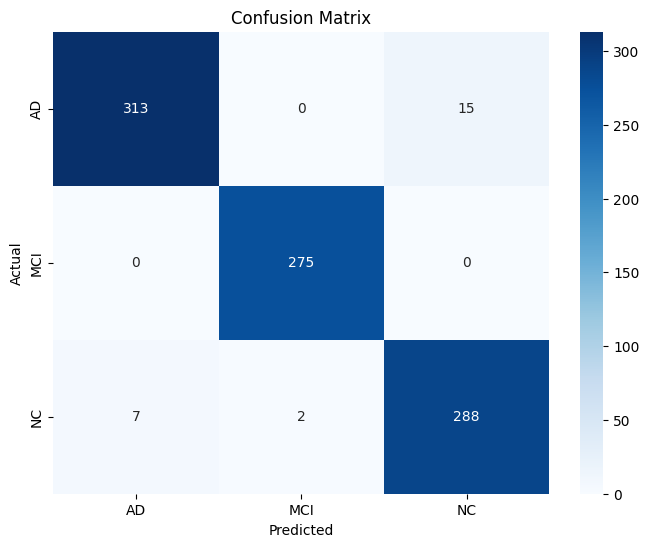

In [87]:
#Now let's show the confusion matrix.
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#Comments: 98% accuracy of Alzheimer’s Disease detection (That's exactly what we want, we prefered to detect the person who have disease 98% accuracy over than detect normal person 95% accuracy).
#Let's try other models as RandomForest and CNN"

2- Second Model Random Forest

In [88]:
#We will take the prepared data from PCA then will apply Grid Search to get best parameters for Random Forest

#Now let's prepare our model 
rf = RandomForestClassifier(random_state=42)

#Prepare some parameters to test them using Grid search and get the bettter results
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

#Apply Grid Search to get the best parameters for best accurecy
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train_pca, ytrain)

#now let's get the best model
best_rf = grid_search.best_estimator_

#and finally let's test this model
y_pred = best_rf.predict(X_test_pca)

#now calculate the accuracy of the model
accuracy = accuracy_score(ytest, y_pred) * 100

#Print results of best parameters for this case and the accuracy
print(f"Best Parameters from GridSearchCV: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters from GridSearchCV: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 95.6667


In [89]:
#Now let's see the classification report to know more about classification results
class_report = classification_report(ytest, y_pred, target_names=['AD', 'MCI', 'NC'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          AD       0.97      0.94      0.95       328
         MCI       0.97      1.00      0.99       275
          NC       0.93      0.94      0.93       297

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



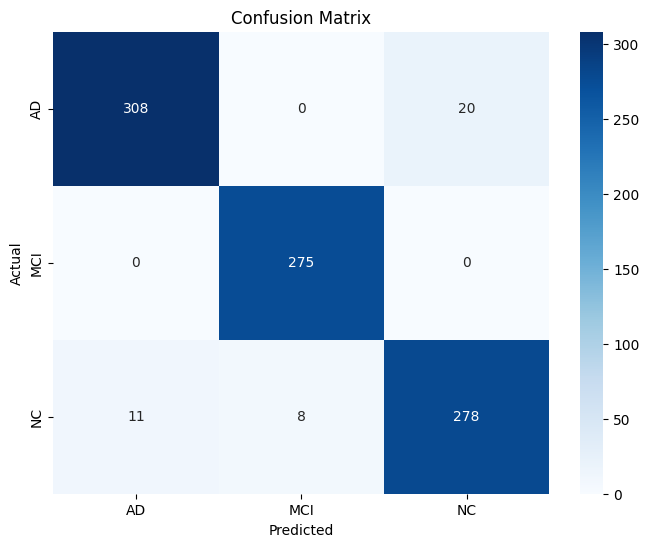

In [90]:
#Now let's show the confusion matrix.
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
#About 1% less than svm in total accuracy, also in AD detection.
#Let's try CNN"

3- Third Model Convolution Neural Network (CNN)

In [91]:
#Section 1 preparing train and test splits

#Get the images again from the copy
images = images_copy[:]
#Normalize the data between 0 and 1
images = images.astype('float32') / 255.0
#Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
#Apply One hot encoding
labels = to_categorical(labels, num_classes=3)
#Train Test Splits
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size=0.3, random_state=42)

In [92]:
#Section 2 CNN

model = Sequential()
#first layer 32 filters
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#second layer 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#third layer 128 filters
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#forth layer 256 filters
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#flatten the data
model.add(Flatten())
#apply dense layer (fully connected layer), also add Dropout layer to prevent overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
#now add output layer that exit probability for each class from the 3 classes
model.add(Dense(3, activation='softmax'))
#prepare the optimizer
selected_optimizer = Adam(learning_rate=0.0001)
#now compile the model
model.compile(optimizer=selected_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#early stopping in case no progress of accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#pass the train and test data
history = model.fit(xtrain, ytrain, batch_size=64, epochs=30, validation_data=(xtest, ytest), callbacks=[early_stopping])
#finaly get the results
loss, accuracy = model.evaluate(xtest, ytest)
print(f"Test accuracy: {accuracy * 100:.2f}%")

c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 216s 6s/step - accuracy: 0.5866 - loss: 0.8556 - val_accuracy: 0.8544 - val_loss: 0.3890
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.8631 - loss: 0.3496 - val_accuracy: 0.8944 - val_loss: 0.2700
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8910 - loss: 0.2794 - val_accuracy: 0.8989 - val_loss: 0.2558
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8963 - loss: 0.2715 - val_accuracy: 0.8900 - val_loss: 0.2677
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9029 - loss: 0.2581 - val_accuracy: 0.9000 - val_loss: 0.2363
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9051 - loss: 0.2504 - val_accuracy: 0.9011 - val_loss: 0.2341
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8998 - loss: 0.2479 - val_accuracy: 0.9033 - val_loss: 0.2261
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.9094 - loss: 0.2214 - val_accuracy: 0.9100 - v

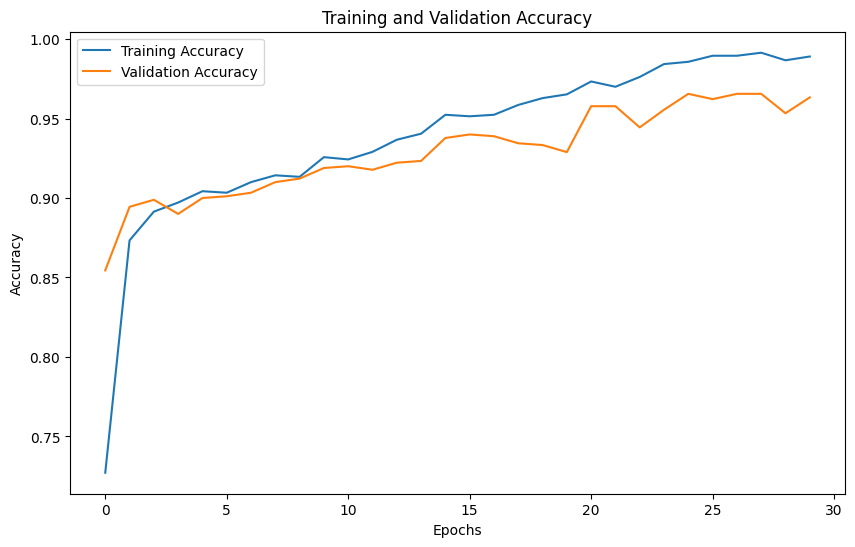

In [93]:
#Show accuracy graph in training vs testing phases
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

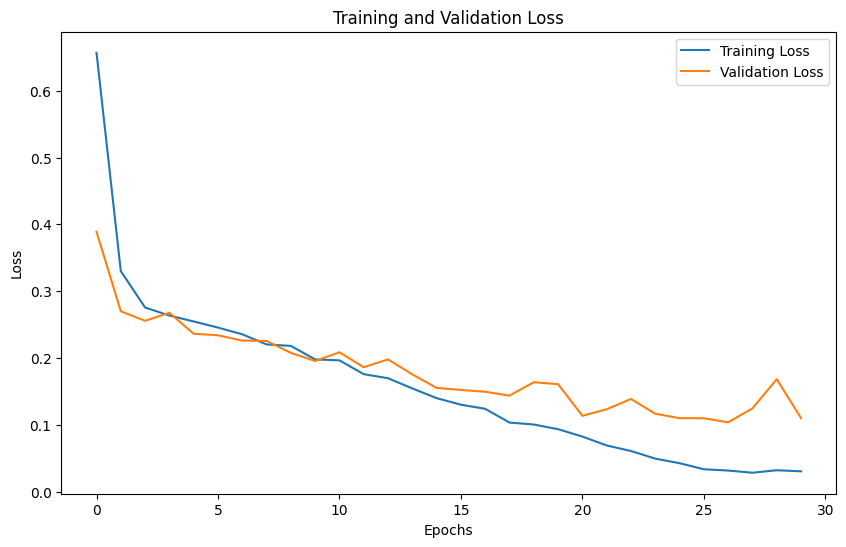

In [94]:
#Loss graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
#Classification report
y_pred = model.predict(xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(ytest, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['AD', 'MCI', 'NC']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step
Classification Report:
              precision    recall  f1-score   support

          AD       0.96      0.96      0.96       328
         MCI       0.98      1.00      0.99       275
          NC       0.96      0.94      0.95       297

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



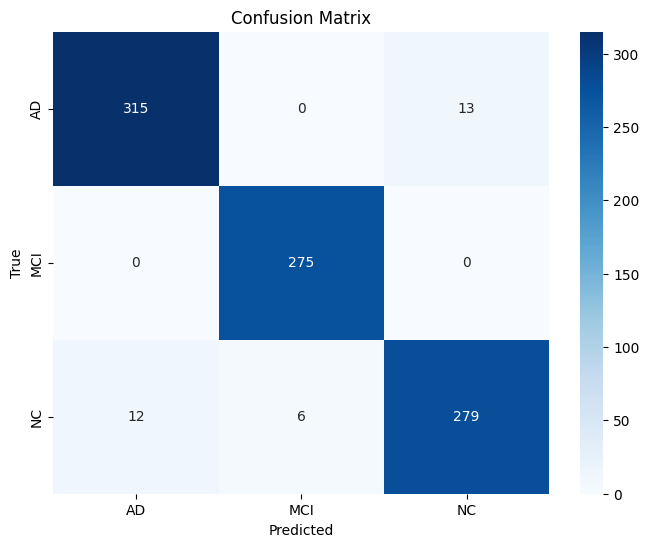

In [96]:
#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AD', 'MCI', 'NC'], yticklabels=['AD', 'MCI', 'NC'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()